# Designing for Guidance in Machine Learning

Olivia Gunton • Data Scientist @ Textio • PyData Seattle 2017 - 7/6/2017

_How does the task of developing a machine learning system change when we not only have to predict outcomes from inputs, but also guide users to make their inputs better? Using practical examples in Python, I'll explore some of the lessons we've learned building an augmented writing platform at Textio._

## Black-box model: TensorFlow

See [TensorFlow MNIST advanced tutorial code](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/mnist)

## Explainable model: decision tree classifier using pixel values

In [26]:
from IPython.display import display, Image
import pandas as pd
import pydotplus
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [27]:
df = pd.read_csv('ones_and_sevens.csv')  # filtered version of MNIST training dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9085 entries, 0 to 9084
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 54.4 MB


In [28]:
list(df)

['label',
 'pixel0',
 'pixel1',
 'pixel2',
 'pixel3',
 'pixel4',
 'pixel5',
 'pixel6',
 'pixel7',
 'pixel8',
 'pixel9',
 'pixel10',
 'pixel11',
 'pixel12',
 'pixel13',
 'pixel14',
 'pixel15',
 'pixel16',
 'pixel17',
 'pixel18',
 'pixel19',
 'pixel20',
 'pixel21',
 'pixel22',
 'pixel23',
 'pixel24',
 'pixel25',
 'pixel26',
 'pixel27',
 'pixel28',
 'pixel29',
 'pixel30',
 'pixel31',
 'pixel32',
 'pixel33',
 'pixel34',
 'pixel35',
 'pixel36',
 'pixel37',
 'pixel38',
 'pixel39',
 'pixel40',
 'pixel41',
 'pixel42',
 'pixel43',
 'pixel44',
 'pixel45',
 'pixel46',
 'pixel47',
 'pixel48',
 'pixel49',
 'pixel50',
 'pixel51',
 'pixel52',
 'pixel53',
 'pixel54',
 'pixel55',
 'pixel56',
 'pixel57',
 'pixel58',
 'pixel59',
 'pixel60',
 'pixel61',
 'pixel62',
 'pixel63',
 'pixel64',
 'pixel65',
 'pixel66',
 'pixel67',
 'pixel68',
 'pixel69',
 'pixel70',
 'pixel71',
 'pixel72',
 'pixel73',
 'pixel74',
 'pixel75',
 'pixel76',
 'pixel77',
 'pixel78',
 'pixel79',
 'pixel80',
 'pixel81',
 'pixel82',
 'pi

[ 0.98955379  0.98873612  0.9923884   0.99102787] 0.990426545399


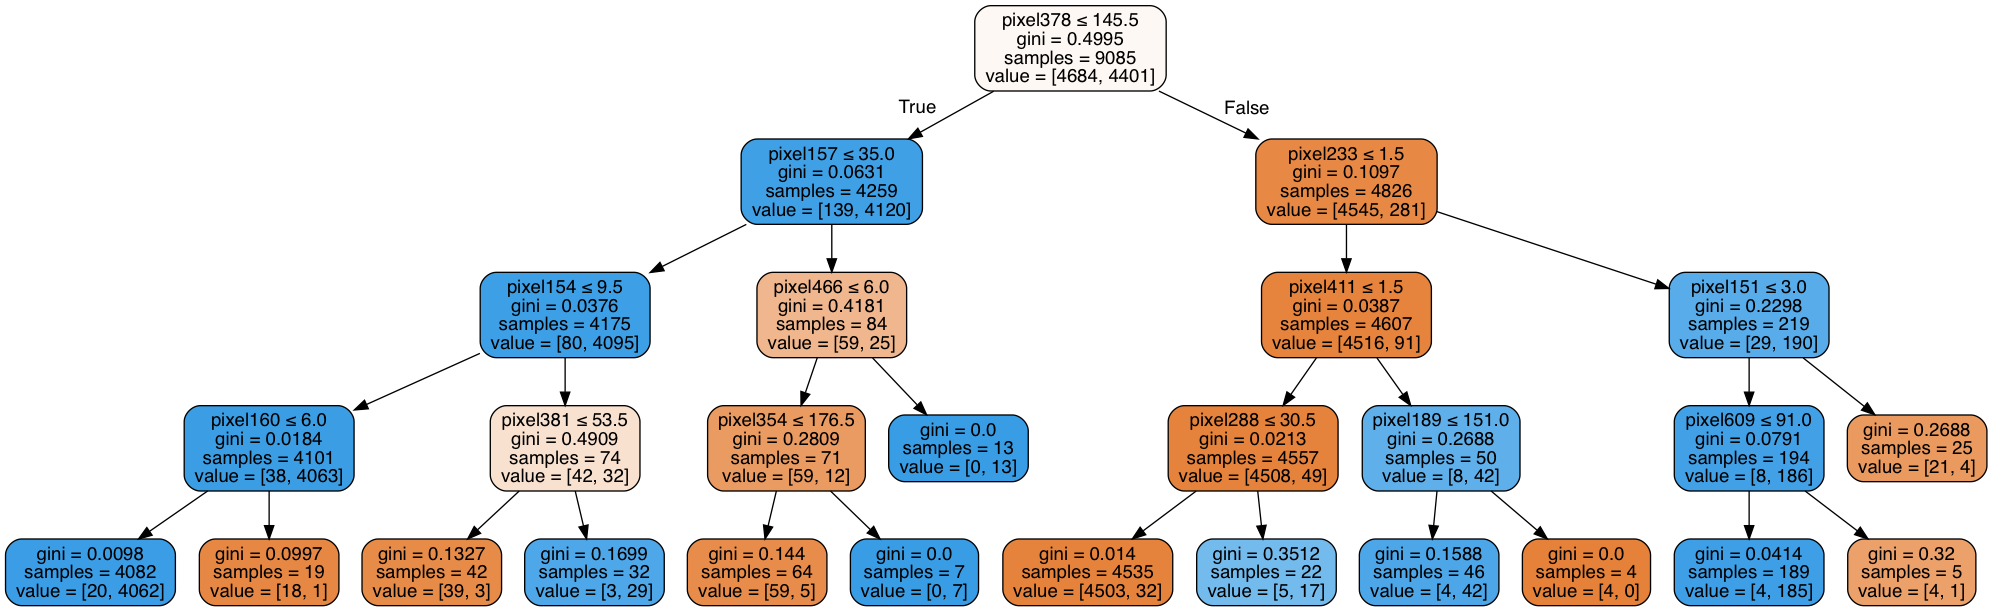

In [29]:
df['label_binary'] = df['label'].apply(lambda label: 1 if label == 7 else 0)

X = df[list(df)[1:-1]]  # all pixel columns
y = df['label_binary']

clf = DecisionTreeClassifier(max_depth=4, min_samples_split=50, random_state=1)
clf.fit(X, y)
cv_scores = cross_val_score(clf, X, y, cv=4, scoring='roc_auc')
print(cv_scores, cv_scores.mean())

# visualize decision tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Guidance-producing model: decision tree classifier using engineered features

In [30]:
%matplotlib inline

import math
import random

import cv2
from IPython.display import display, Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
from scipy.misc import imresize
from skimage.morphology import skeletonize
from sklearn.externals.six import StringIO  
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz, DecisionTreeClassifier

In [31]:
def cols_to_img(df_row):
    """Given a row of a dataframe containing the pixel values of an image, return the image as an array
    as it would be displayed in matplotlib (makes for larger, more human-viewable images).
    Assumes the only columns with 'pixel' in the name are the ones that contain the pixel values -- will break
    if not.
    """
    
    IMG_INITIAL_DIM = 28
    IMG_FINAL_DIM = 400
    MAX_PIXEL_VAL = 255
    
    pixel_cols = [colname for colname in list(df_row.index) if 'pixel' in colname]
    
    reshaped = df_row[pixel_cols].values.reshape(IMG_INITIAL_DIM, IMG_INITIAL_DIM)
    
    resized = imresize(reshaped, (IMG_FINAL_DIM, IMG_FINAL_DIM), interp='bilinear') # mimic what plt.imshow() did
    
    black_on_white = (MAX_PIXEL_VAL - resized) # invert colors to look like pen on paper
    
    return black_on_white
    

def save_and_display(img, img_name):
    """Save img to jpeg and display it in the Jupyter cell output area
       (Mostly for debugging purposes)"""
    filename = '{}.jpg'.format(img_name)
    cv2.imwrite(filename, img)
    display(Image(filename))

    
def blur(img):
    """Smooth/reduce noise by applying normalized box filter, with kernel size K_WIDTH x K_HEIGHT"""
    K_WIDTH = 50
    K_HEIGHT = 50
    
    return cv2.blur(img, (K_WIDTH, K_HEIGHT))


def bw(img):
    """Threshold greyscale image to black and white""" 
    THRESH = 200
    MAX_VALUE = 255
    
    _, thresholded_img = cv2.threshold(img, THRESH, MAX_VALUE, cv2.THRESH_BINARY)
    
    return thresholded_img


def skel(img):
    """Skeletonize inverted image and return re-inverted skeleton (thinning algorithm takes a white-on-black image)."""
    skel = skeletonize(img + 1)  # from skimage.morphology
    return (~skel).astype(np.uint8) * 255 # re-invert image


def preprocess(img):
    """Run image through entire pipeline of pre-processing steps before line and corner detection"""
    blurred = blur(img)
    black_and_white = bw(blurred)
    skeleton = skel(black_and_white)
    return skeleton


def lines_are_close(line_a, line_b):
    """Determine if lines' origins and angles are close enough to consider them equal for the purposes of filtering
   the output of cv2.HoughLinesP.
   Without filtering, HoughLinesP tends to return 2-3x as many lines as we need without adding much information
   about the underlying shape.
   """
    x = line_a['x1'] - line_b['x1']
    y = line_a['y1'] - line_b['y1']

    distance_bw_origins = math.hypot(x, y)

    angle_diff = abs(line_a['angle'] - line_b['angle'])

    if distance_bw_origins <= 20 or angle_diff <= 10:
        return True

    return False


def line_already_exists(ld, keep_lines):
    """Helper for find_lines to allow us to easily stop comparing lines once we find a matching one."""
    if len(keep_lines) == 0:
        return False

    for kl in keep_lines:
        if lines_are_close(ld, kl):
            return True

    return False


def find_lines(img):
    """Use probabalistic Hough line transform to find line segments in img.
    Filters out extraneous lines and returns a list of the lines as dicts containing these attributes:
       x1, x2, y1, y2: x and y coordinates of endpoints
       length: length in pixels
       angle: angle in degrees relative to horizontal (90 is vertical)
    Assumes input image has already been run through preprocessing pipeline.
    """
    
    # sensitivity/other parameters for Hough Lines
    RHO = 1
    THETA = np.deg2rad(10)
    THRESHOLD = 20
    MIN_LINE_LENGTH = 30
    MAX_LINE_GAP = 10
    
    houghlines = cv2.HoughLinesP(~img, rho=RHO, theta=THETA, threshold=THRESHOLD, 
                                 minLineLength=MIN_LINE_LENGTH, maxLineGap=MAX_LINE_GAP)
    
    line_dicts = []
    
    if houghlines is None:
        return None
    
    for hl in houghlines:
        x1, y1, x2, y2 = hl[0] # nested array with one element
        x = x2 - x1
        y = y2 - y1

        length = math.hypot(x, y)

        angle = abs(math.atan2(y, x) * 180 / math.pi)

        line_dict = {'x1': x1,
                     'y1': y1,
                     'x2': x2,
                     'y2': y2,
                     'length': length,
                     'angle': angle}

        line_dicts.append(line_dict)
    
    lines_to_keep = []
    
    for ld in line_dicts:
        if not(line_already_exists(ld, lines_to_keep)):
            lines_to_keep.append(ld)
            
    return lines_to_keep


def is_horizontal(line):
    """Check if line is roughly horizontal based on its angle (around 0 or 180 degrees,
    plus or minus some wiggle room).
    """  
    if line['angle'] <= 22.5 or line['angle'] > 157.5:
        return True
    
    return False
    
def is_vertical(line):
    """Check if line is roughly vertical based on its angle (around 90 degrees,
    plus or minus some wiggle room).
    """   
    if line['angle'] > 67.5 and line['angle'] <= 112.5:
        return True
    
    return False

def count_horizontal(lines_list):
    """Return the number of horizontal lines in a list of line_dicts."""
    
    if lines_list is None:
        return 0
    else:
        return sum([1 for line in lines_list if is_horizontal(line)])
    
def count_vertical(lines_list):
    """Return the number of vertical lines in a list of line_dicts."""
    
    if lines_list is None:
        return 0
    else:
        return sum([1 for line in lines_list if is_vertical(line)])


    
def corner_quadrant(x, y):
    """Given the coordinates of a corner returned by cv2.goodFeaturesToTrack, determine which quadrant it appears in
       in the image and return a string describing that quadrant.
       Assumes 400 x 400 image."""  
    if(x <= 200):
        if (y <= 200):
            return 'upper left'
        else:
            return 'lower left'
    else:
        if (y <= 200):
            return 'upper right'
        else:
            return 'lower right'
        
    
def find_corners(img):
    """Return a list of the strongest corners in img as (x, y) coordinates
    Assumes input image has already been run through preprocessing pipeline.
    Return flat list of tuples so we can apply() this function without getting "data must be 1-dimensional" error
    """
    MAX_CORNERS = 3
    QUALITY_LEVEL = .01
    MIN_DISTANCE = 10
    
    corners_array = cv2.goodFeaturesToTrack(img, MAX_CORNERS, QUALITY_LEVEL, MIN_DISTANCE)
    
    corners_list = []
    for row in corners_array:
        # Flatten and convert to tuple
        x, y = tuple(row[0])
        quadrant = corner_quadrant(x, y)
        corner_dict = {'x': x,
                       'y': y,
                       'quadrant': quadrant
                      }
        corners_list.append(corner_dict)
    
    return corners_list

def count_corners_in_quadrant(corners_list, quadrant_string):
    return sum([1 for corner in corners_list if corner['quadrant'] == quadrant_string])

def remove_borders(img):
    """Remove extraneous black border lines created by cv2's image rotation."""
    WHITE_PIXEL = 255
    
    rows, cols = img.shape
    for i in range(0, rows):
        img[0][i] = WHITE_PIXEL
    
    for j in range(0, cols):
        img[j][0] = WHITE_PIXEL
        
    return img

def rotate(img, deg=180):
    """Return img rotated by deg degrees"""
    rows, cols = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), deg, 1)
    rotated = remove_borders(cv2.warpAffine(img,M,(cols,rows)))

    return rotated

def is_diagonal(line):
    """Check if line is neither horizontal nor vertical based on its angle."""
    if not(is_horizontal(line)) and not (is_vertical(line)):
        return True
    
    return False


def count_diagonal(lines_list):
    """Return the number of horizontal lines in a list of line_dicts."""
    
    if lines_list is None:
        return 0
    else:
        return sum([1 for line in lines_list if is_diagonal(line)])

random numeral:


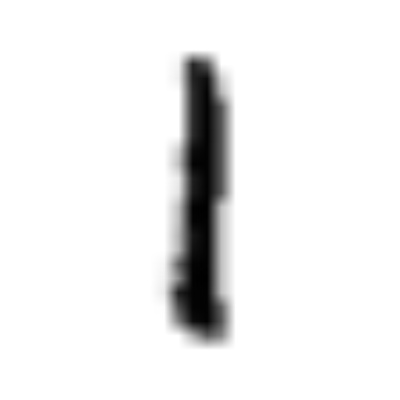

blurred:


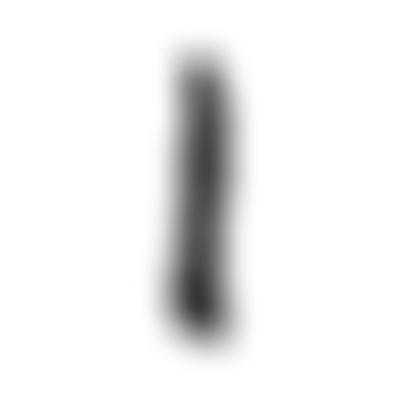

thresholded:


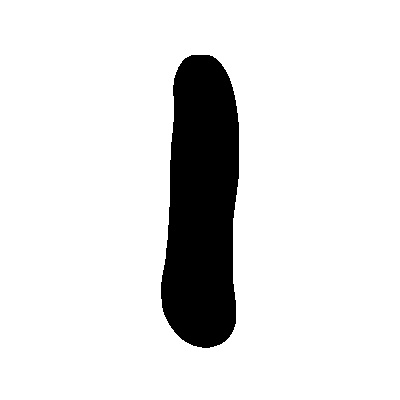

skeletonized:


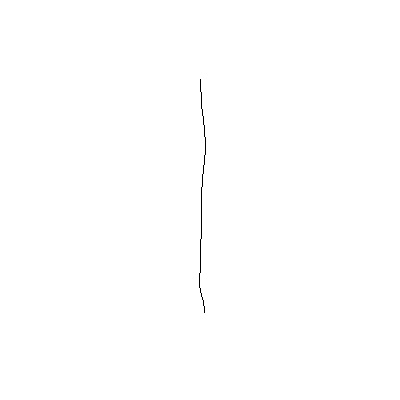

In [32]:
# check preprocessing steps

random_row_num = random.randint(0, len(df) - 1)

print("random numeral:")
img = cols_to_img(df.iloc[random_row_num])
save_and_display(img, 'random')

print("blurred:")
blurred = blur(img)
save_and_display(blurred, 'blurred')

print("thresholded:")
black_and_white = bw(blurred)
save_and_display(black_and_white, 'bw')

print("skeletonized:")
skeleton = skel(black_and_white)
save_and_display(skeleton, 'skeleton')

In [33]:
df = pd.read_csv('ones_and_sevens.csv')
df['label_binary'] = df['label'].apply(lambda label: 1 if label == 7 else 0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9085 entries, 0 to 9084
Columns: 786 entries, label to label_binary
dtypes: int64(786)
memory usage: 54.5 MB


[ 0.97970675  0.98360104  0.9800458   0.9841635 ] 0.981879272455


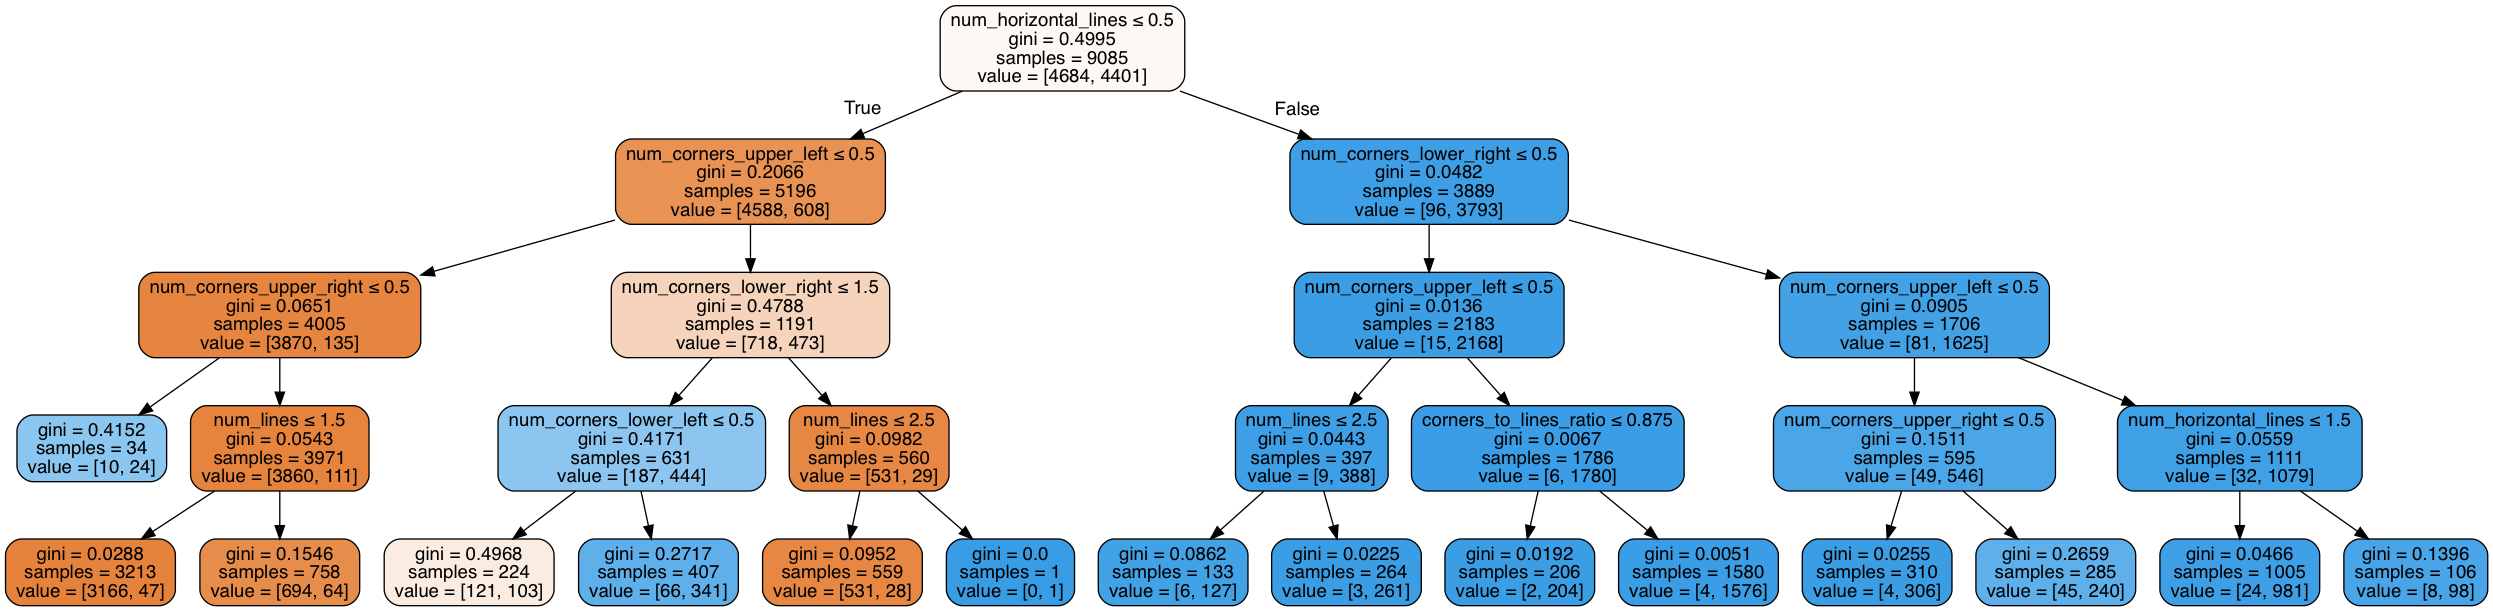

In [34]:
# detect and count lines

df['lines'] = df.apply(lambda row: find_lines(preprocess(cols_to_img(row))), axis=1)
df['num_lines'] = df['lines'].apply(lambda lines_list: len(lines_list) if lines_list is not None else 0)
df['num_horizontal_lines'] = df['lines'].apply(count_horizontal)
df['num_vertical_lines'] = df['lines'].apply(count_vertical)

# detect and count corners

df['corners'] = df.apply(lambda row: find_corners(preprocess(cols_to_img(row))), axis=1)
df['num_corners'] = df['corners'].apply(lambda corners_list: len(corners_list) if corners_list is not None else 0)
df['num_corners_upper_left'] = df['corners'].apply(lambda corners_list: count_corners_in_quadrant(corners_list, 
                                                                                                  'upper left'))
df['num_corners_upper_right'] = df['corners'].apply(lambda corners_list: count_corners_in_quadrant(corners_list, 
                                                                                                   'upper right'))
df['num_corners_lower_left'] = df['corners'].apply(lambda corners_list: count_corners_in_quadrant(corners_list, 
                                                                                                  'lower left'))
df['num_corners_lower_right'] = df['corners'].apply(lambda corners_list: count_corners_in_quadrant(corners_list, 
                                                                                                   'lower right'))
df['corners_to_lines_ratio'] = df.apply(lambda row: 
                                        row['num_corners'] / row['num_lines'] if row['num_lines'] > 0 else 0, 
                                        axis=1)

# learn model based on new features

X = df[['num_lines', 'num_corners', 'corners_to_lines_ratio', 'num_horizontal_lines', 'num_vertical_lines',
        'num_corners_upper_left', 'num_corners_upper_right', 'num_corners_lower_left', 'num_corners_lower_right']]
y = df['label_binary']

clf = DecisionTreeClassifier(max_depth=4, min_samples_split=50, random_state=1)
clf.fit(X, y)
cv_scores = cross_val_score(clf, X, y, cv=4, scoring='roc_auc')
print(cv_scores, cv_scores.mean())

dot_data = StringIO() 

export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Random seven:


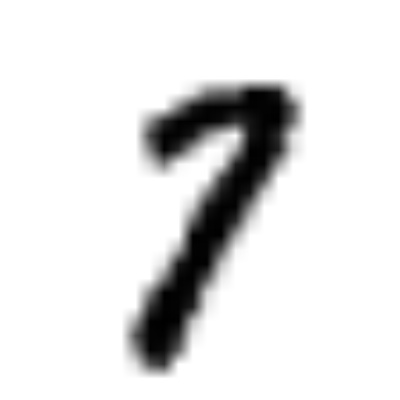

Rotated:


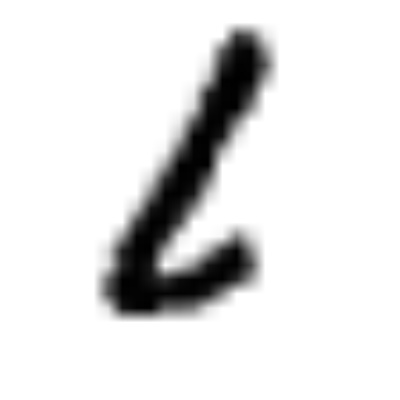

In [35]:
# our model has good AUC, but num_horizontal_lines is suspiciously good at separating the data.
# think about other shapes a user might draw when they have a 1 and are given the guidance "add a horizontal line"
# capital "L" is a shape we should probably account for, so let's rotate our sevens and add them back into the dataset

sevens = df[df['label'] == 7]

random_row_num = random.randint(0, len(sevens) - 1)

img = cols_to_img(sevens.iloc[random_row_num])
print("Random seven:")
save_and_display(img, 'random_seven')

rotated = rotate(img, 180)
print("Rotated:")
save_and_display(rotated, 'rotated')

In [36]:
sevens[list(sevens)[:785]].to_csv('sevens_to_rotate.csv', index=False)

[ 0.96596004  0.97266463  0.7981602   0.78967755] 0.881615606134


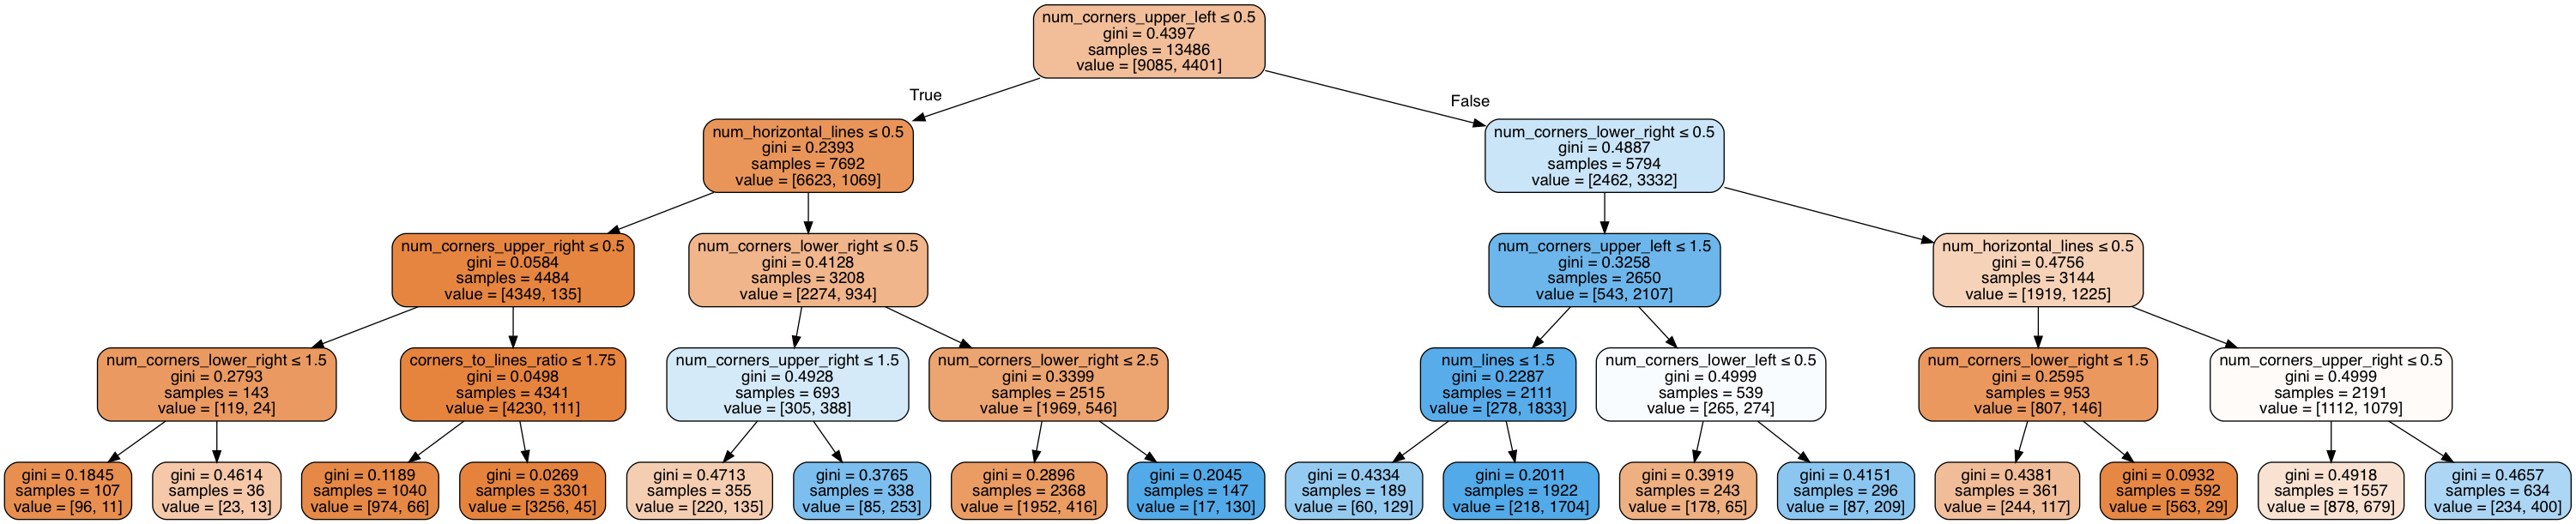

In [37]:
# calculate feature values from rotated images and relabel as "not-sevens"
ells = sevens[list(sevens)[:785]].copy(deep=True) # cut to only necessary cols, copy to avoid SettingWithCopyWarning

ells['lines'] = ells.apply(lambda row: find_lines(rotate(preprocess(cols_to_img(row)))), axis=1)
ells['num_lines'] = ells['lines'].apply(lambda lines_list: len(lines_list) if lines_list is not None else 0)
ells['num_horizontal_lines'] = ells['lines'].apply(count_horizontal)
ells['num_vertical_lines'] = ells['lines'].apply(count_vertical)

ells['corners'] = ells.apply(lambda row: find_corners(rotate(preprocess(cols_to_img(row)))), axis=1)
ells['num_corners'] = ells['corners'].apply(lambda corners_list: len(corners_list) if corners_list is not None else 0)
ells['corners_to_lines_ratio'] = ells.apply(lambda row: 
                                            row['num_corners'] / row['num_lines'] if row['num_lines'] > 0 else 0, 
                                            axis=1)
ells['num_corners_upper_left'] = ells['corners'].apply(lambda corners_list: count_corners_in_quadrant(corners_list, 
                                                                                                      'upper left'))
ells['num_corners_upper_right'] = ells['corners'].apply(lambda corners_list: count_corners_in_quadrant(corners_list, 
                                                                                                       'upper right'))
ells['num_corners_lower_left'] = ells['corners'].apply(lambda corners_list: count_corners_in_quadrant(corners_list, 
                                                                                                      'lower left'))
ells['num_corners_lower_right'] = ells['corners'].apply(lambda corners_list: count_corners_in_quadrant(corners_list, 
                                                                                                       'lower right'))

ells['label_binary'] = 0

# append to our original dataset
df = df.append(ells)

# rev model with new data
X = df[['num_lines', 'num_corners', 'corners_to_lines_ratio', 'num_horizontal_lines', 'num_vertical_lines',
        'num_corners_upper_left', 'num_corners_upper_right', 'num_corners_lower_left', 'num_corners_lower_right']]
y = df['label_binary']

clf = DecisionTreeClassifier(max_depth=4, min_samples_split=50, random_state=1)
clf.fit(X, y)
cv_scores = cross_val_score(clf, X, y, cv=4, scoring='roc_auc')
print(cv_scores, cv_scores.mean())

dot_data = StringIO() 

export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

[ 0.97222775  0.97524138  0.85435311  0.84882651] 0.912662188065


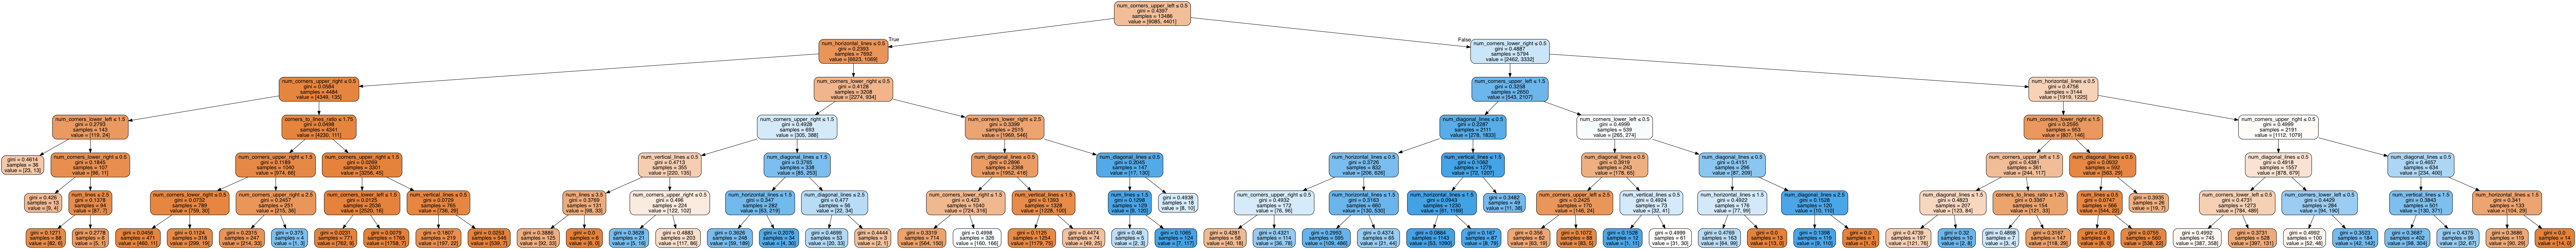

In [38]:
# add one more feature and a few decision tree levels to show that small tweaks can get performance back up

df['num_diagonal_lines'] = df['lines'].apply(count_diagonal)

X = df[['num_lines', 'num_corners', 'corners_to_lines_ratio', 'num_horizontal_lines', 
        'num_vertical_lines', 'num_corners_upper_left', 'num_corners_upper_right', 
        'num_corners_lower_left', 'num_corners_lower_right', 'num_diagonal_lines'
      ]]
y = df['label_binary']

clf = DecisionTreeClassifier(max_depth=6, min_samples_split=50, random_state=1)
clf.fit(X, y)
cv_scores = cross_val_score(clf, X, y, cv=4, scoring='roc_auc')
print(cv_scores, cv_scores.mean())

dot_data = StringIO() 

export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())